In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree

from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
income = pd.read_csv('adult_income.csv')

In [3]:
income.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
income.columns = income.columns.str.replace('.','_')

In [5]:
income['income_map'] = income.income.map({'<=50K':0, '>50K': 1})
income['sex_map'] = income.sex.map({'Female':0, 'Male':1})
income['race_map']=income.race.map({'White':0, 'Black':1, 
                                    'Asian-Pac-Islander':2, 'Amer-Indian-Eskimo':3})
income['marital_map'] = income.marital_status.map({'Widowed':0, 'Divorced':1, 'Separated':2,
                                                  'Never-married':3, 'Married-civ-spouse':4,
                                                  'Married-spouse-absent':5, 'Married-AF-spouse':6})
income['rel_map']=income.relationship.map({'Not-in-family':0, 'Unmarried':0, 
                                           'Own-child':0, 'Other-relative':0, 
                                           'Husband':1, 'Wife':1})
income['work_map']=income.workclass.map({'?':0, 'Private':1, 'State-gov':2, 'Federal-gov':3, 
                                        'Self-emp-not-inc':4, 'Self-emp-inc': 5, 'Local-gov': 6,
                                        'Without-pay':7, 'Never-worked':8})

In [6]:
num_cols = ['age', 'sex_map', 'race_map','education_num', 'work_map', 
            'marital_map', 'rel_map', 'hours_per_week','capital_gain', 'capital_loss', 
            'fnlwgt', 'income_map']

In [7]:
income=income[num_cols].dropna()

In [8]:
income.head()

,age,sex_map,race_map,education_num,work_map,marital_map,rel_map,hours_per_week,capital_gain,capital_loss,fnlwgt,income_map
0,90,0,0.0,9,0,0,0,40,0,4356,77053,0
1,82,0,0.0,9,1,0,0,18,0,4356,132870,0
2,66,0,1.0,10,0,0,0,40,0,4356,186061,0
3,54,0,0.0,4,1,1,0,40,0,3900,140359,0
4,41,0,0.0,10,1,2,0,40,0,3900,264663,0


In [9]:
features=['age', 'sex_map', 'race_map','education_num', 'work_map', 
          'marital_map', 'rel_map', 'hours_per_week','capital_gain', 
          'capital_loss', 'fnlwgt']

target=['income_map']

In [10]:
X = income[features].values
y = income[target].values.flatten()

# Logistic Regression

First let's test the accuracy of our model using all the features in the feature list.

In [11]:
logreg = LogisticRegression()

In [12]:
cv_score1 = cross_val_score(logreg,X,y,cv=10, scoring='accuracy').mean()

In [13]:
print('Model accuracy: {}'.format(cv_score1))

Model accuracy: 0.7685318908885534


Now we'll use recursive feature elimination (rfe) in order to reduce the number of 
features used to make a prediction down to the seven key features. Then we'll test the model's performance again.

In [14]:
selector = RFE(logreg, 7, step=1)

In [15]:
selector = selector.fit(X, y)

In [16]:
lr_features = income[features].columns[selector.support_ ]

In [17]:
X_lr = income[lr_features].values

In [18]:
cv_score2 = cross_val_score(logreg,X_lr,y,cv=10, scoring='accuracy').mean()

In [19]:
print('Model accuracy: {}'.format(cv_score2))

Model accuracy: 0.8200990115275804


# K Nearest Neighbors Classifier

In [20]:
knn= KNeighborsClassifier(n_neighbors=5)
cv_score_knn = cross_val_score(knn, X_lr, y, cv=10, scoring='accuracy').mean()

In [21]:
print('Model accuracy: {}'.format(cv_score_knn))

Model accuracy: 0.802539595505967


Below we'll use the same cross validation technique used above within a for loop.
This loop will vary the number of neighbors (k) used to classify in order to optomize
the value of parameter k.

In [22]:
k_range = range(1, 31)
k_scores = []
for k in k_range:
    knn= KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,X_lr,y,cv=10,scoring='accuracy')
    k_scores.append(scores.mean())

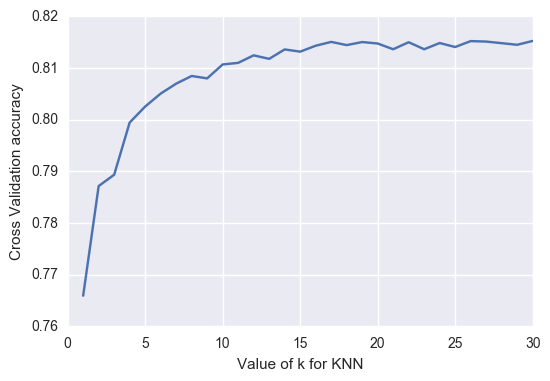

In [23]:
plt.plot(k_range,k_scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Cross Validation accuracy')

# Extra Tree Classifier

In [24]:
extree = ExtraTreesClassifier()
cv_score_et = cross_val_score(extree,X_lr,y,cv=10).mean()

In [25]:
print('Model accuracy: {}'.format(cv_score_et))

Model accuracy: 0.8022301706326523


In [26]:
extree.fit(X_lr,y)
feats = extree.feature_importances_

([<matplotlib.axis.YTick at 0x10b9ad198>,
 <a list of 7 Text yticklabel objects>)

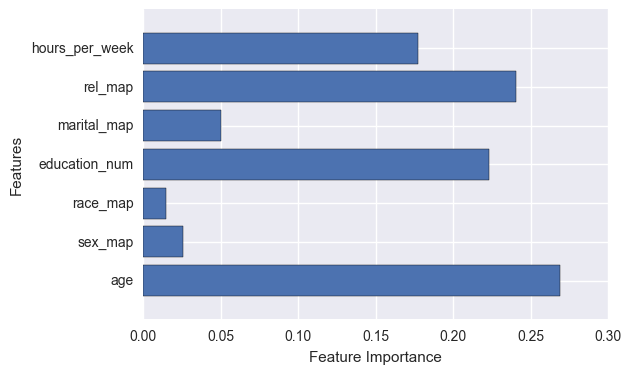

In [27]:
pos = np.arange(len(income[lr_features].columns))+1
plt.barh(pos, feats, align='center')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.yticks(pos, (income[lr_features].columns))

# Decision Tree Classifier

In [28]:
clf = tree.DecisionTreeClassifier()
cv_score_tr = cross_val_score(clf,X_lr,y,cv=10).mean()

In [29]:
print('Model accuracy: {}'.format(cv_score_tr))

Model accuracy: 0.7925675918141211
